In [1]:
%pylab inline
from astropy.cosmology import Planck13
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars

Populating the interactive namespace from numpy and matplotlib


In [2]:
# cover 1000A to 20um at R=1000
wave = sqbase.fixed_R_dispersion(1000,20e4,1000)

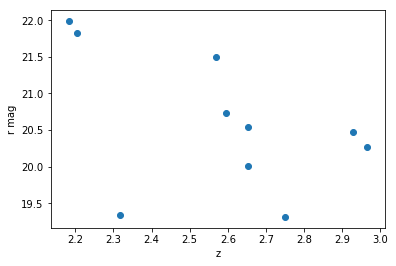

In [3]:
# just make up a few random redshifts between z=2 and z=3, then assign apparent mags according 
# to the BOSS DR9 QLF
nqso = 10
np.random.seed(12345)
zin = 2.0 + np.random.rand(nqso)
kcorr = sqbase.ContinuumKCorr('DECam-r',1450,effWaveBand='SDSS-r')
qsos = generateQlfPoints(BOSS_DR9_PLEpivot(cosmo=Planck13),
                         (17,22),(2.0,3.0),
                         kcorr=kcorr,zin=zin,
                         qlfseed=12345,gridseed=67890)
scatter(qsos.z,qsos.appMag)
xlabel('z')
ylabel('r mag');

In [4]:
# add the fiducial quasar SED model from BOSS DR9, don't add IGM absorption
sedVars = get_BossDr9_model_vars(qsos,wave,0,noforest=True)
qsos.addVars(sedVars)

In [5]:
# need to define photometry in SDSS system in order to calibrate apparent mags
qsos.loadPhotoMap([('DECam','DECaLS'),])

In [6]:
# ready to generate spectra. iteration is necessary to converge on the per-object k-correction,
# after two steps the maximum error on the absolute mags is <<1%
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3,verbose=10)

simulating  10  quasar spectra
units are  flux
buildSpectra iteration  1  out of  3
--> delta mag mean = -0.1698063, rms = 0.0868434, |max| = 0.3055625
buildSpectra iteration  2  out of  3
--> delta mag mean = -0.0172446, rms = 0.0124519, |max| = 0.0384427
buildSpectra iteration  3  out of  3
--> delta mag mean = -0.0004477, rms = 0.0004863, |max| = 0.0014417


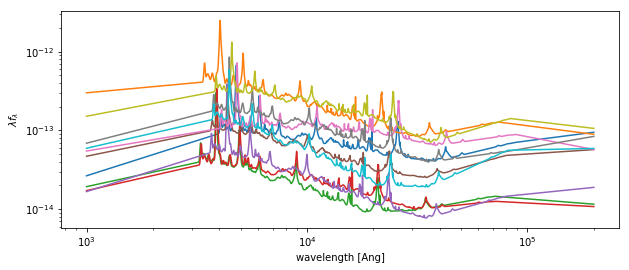

In [7]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$');

In [8]:
# the parameter values for each spectrum
qsos.data

absMag,appMag,z,slopes [5],"emLines [62,3]",synMag [3],synFlux [3]
float32,float32,float32,float32,float32,float32,float32
-24.6707,20.4712,2.92962,-1.88898 .. -1.36107,1033.73 .. 323.155,20.4588 .. 20.3804,6.55341 .. 7.04428
-25.5241,19.3351,2.31638,-1.25556 .. -0.638748,1034.31 .. 324.459,19.14 .. 19.119,22.0807 .. 22.5123
-22.825,21.9865,2.18392,-1.60816 .. -0.775977,1033.7 .. 290.716,21.8311 .. 21.7826,1.85164 .. 1.93626
-22.87,21.8263,2.20456,-1.63361 .. -0.851231,1034.13 .. 311.48,21.7438 .. 21.481,2.00675 .. 2.55634
-23.5573,21.4947,2.56772,-1.87692 .. -1.28331,1033.51 .. 268.032,21.3586 .. 21.4148,2.86137 .. 2.717
-24.3216,20.7288,2.59554,-1.57389 .. -1.18543,1034.34 .. 409.85,20.8099 .. 20.5751,4.74296 .. 5.88766
-24.9189,20.2622,2.96451,-1.47492 .. -0.461103,1033.18 .. 253.642,20.4088 .. 20.0263,6.86248 .. 9.76028
-25.0384,20.0058,2.65318,-1.71456 .. -1.48518,1033.7 .. 270.138,20.0588 .. 19.8753,9.47325 .. 11.2169
-25.7682,19.3137,2.74891,-1.53337 .. -0.670226,1033.58 .. 263.723,19.4303 .. 19.1541,16.9003 .. 21.7949


In [9]:
# save the spectra to a fits bin table
save_spectra(wave,spectra,'quickspeclib')

In [10]:
# restore the spectra
wave,spec = load_spectra('quickspeclib')